In [1]:
%load_ext autoreload
%autoreload 2

In [59]:
import copy
import os
from dataclasses import dataclass, field

from typing import Dict, List, Tuple, Optional, Callable, Any

from collections import defaultdict 

import math
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve

from PIL import Image

from pysolotools.consumers import Solo
from pysolotools.converters.solo2coco import SOLO2COCOConverter
from pysolotools.core.models import KeypointAnnotationDefinition, RGBCameraCapture
from pysolotools.core.models import BoundingBox2DAnnotation as BBox2DAnno, BoundingBox3DAnnotation as BBox3DAnno
from pysolotools.core.models import BoundingBox2DLabel, BoundingBox3DLabel
from pysolotools.core.models import Frame, Capture
from scipy.spatial.transform import Rotation as R

from torchvision.datasets import ImageFolder
from torchvision.models import swin_v2_t, Swin_V2_T_Weights
from torchvision.models import swin_v2_b, Swin_V2_B_Weights
# from torch.utils.data import ConcatDataset, DataLoader
from collections import OrderedDict
from torch.utils.data import DataLoader

import torch
from torch import nn, Tensor

from torch.nn import functional as F
import torchprofile

from torchvision.ops import FeaturePyramidNetwork, MLP, sigmoid_focal_loss
import lightning.pytorch as pl
from lightning.pytorch.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import LearningRateMonitor

import matplotlib.pyplot as plt
from scipy.optimize import linear_sum_assignment
from scipy.io import savemat
# from scipy.linalg.dft as dft
from scipy.linalg import dft

from scipy.io import savemat, loadmat
from sklearn.metrics import auc, roc_curve
from sklearn.metrics import RocCurveDisplay
from scipy.spatial.distance import cdist
from itertools import combinations as CWOR
from itertools import combinations_with_replacement as CWR
from scipy.interpolate import make_interp_spline, BSpline

import reader
import utils
import network
import transformer
import cvmpca_main as cvmpca
from torchvision.ops import FeaturePyramidNetwork
from my_trainer import SetCriterion
import cvmpca_main as cvmpca

torch.set_float32_matmul_precision('medium')
# %matplotlib ipympl

In [60]:
train_folder = 'D:/Unity/dataset/solo'
# training_dir = './data/train'
# testing_dir = './data/test'

transform = Swin_V2_T_Weights.DEFAULT.transforms()
transform.cuda()
backbone = transformer.Swin(is_trainable=False)
backbone.cuda()
backbone.eval()
print()

In [61]:
def cart2sph(coor):  # coor: [M, K, 3]
    x, y, z = coor[:, :, 0], coor[:, :, 1], coor[:, :, 2]
    XsqPlusZsq = x**2 + z**2
    r = np.sqrt(XsqPlusZsq + y**2)                              # r

    elev = np.arccos(np.nan_to_num(y/r))                # theta

    # if XsqPlusZsq == 0:
    #     az = (x==0)*np.sign(z)*np.pi
    # else:
    az = np.sign(z) * np.arccos(np.nan_to_num(x/np.sqrt(XsqPlusZsq))) + (x==0)*np.sign(z)*np.pi 
    return r, az, elev

# def cart2sph(coor):  # coor: [M, K, 3]
#     x, y, z = coor[:, :, 0], coor[:, :, 1], coor[:, :, 2]
#     XsqPlusYsq = x**2 + y**2

#     r = np.sqrt(XsqPlusYsq + z**2)                              # r
#     elev = np.arccos(np.nan_to_num(z/r))                                       # phi
#     az = np.sign(y) * np.arccos(np.nan_to_num(x/XsqPlusYsq))  + (x==0)*np.sign(y)*np.pi   # theta
#     return r, az, elev

def path_gain(dist, freq):      # dist in meters, freq in GHz
    c = 3e8
    return 10**(-(32.4+17.3*np.log10(dist)+20*np.log10(freq))/10), \
           10**(-(32.4+20*np.log10(freq)+31.9*np.log10(dist))/10), \
           10**(-(31.84+21.50*np.log10(dist)+19*np.log10(freq))/10), \
           (c / (4*np.pi*dist*freq*1e9))**2

def UPA_array_response(theta, phi, N_h, N_v):
    M, K = np.shape(theta)
    a2 = (ULA_array_response_2(theta, phi, N_h)[..., None] * np.expand_dims(ULA_array_response_1(theta, phi, N_v), -2)).reshape(M, K, -1)
    return a2

def ULA_array_response_2(theta, phi, N):
    if len(theta.shape) == 2:
        a = 1/np.sqrt(N) * np.exp(
            -1j*np.pi*np.sin(theta)[..., None]*np.sin(phi)[..., None]*np.reshape(np.arange(N), [1, 1, N])
        )
        
    else:
        a = 1/np.sqrt(N) * np.exp(
            -1j*np.pi*np.sin(theta)*np.sin(phi)*np.arange(N)
        )
    # print(np.linalg.norm(a[0,0]))
    return a

def ULA_array_response_1(theta, phi, N):
    if len(theta.shape) == 2:
        a = 1/np.sqrt(N) * np.exp(-1j*np.pi*np.cos(phi)[..., None]*np.reshape(np.arange(N), [1, 1, N]))
        
    else:
        a = 1/np.sqrt(N) * np.exp(
            -1j*np.pi*np.cos(phi)*np.arange(N)
        )
        
    return a

# def ULA_array_response_2(theta, phi, N):
#     if len(theta.shape) == 2:
#         a = 1/np.sqrt(N) * np.exp(
#             -1j*np.pi*np.cos(theta)[..., None]*np.sin(phi)[..., None]*np.reshape(np.arange(N), [1, 1, N])
#         )
        
#     else:
#         a = 1/np.sqrt(N) * np.exp(
#           -1j*np.pi*np.cos(theta)*np.sin(phi)*np.arange(N)
#         )
#     # print(np.linalg.norm(a[0,0]))
#     return a

# def ULA_array_response_1(theta, phi, N):
#     if len(theta.shape) == 2:
#         a = 1/np.sqrt(N) * np.exp(-1j*np.pi*np.sin(phi)[..., None]*np.sin(theta)[..., None]*np.reshape(np.arange(N), [1, 1, N]))
        
#     else:
#         a = 1/np.sqrt(N) * np.exp(
#         -1j*np.pi*np.sin(phi)*np.sin(theta)*np.arange(N)
#         )
#     return a


def cell_association(required_rate, beam_gain, V_max, noise):
    M, K = beam_gain.shape
    options = []
    for i in range(V_max):
        for ids in CWOR(np.arange(K), i+1):
            temp = np.zeros(K) # _temp.copy()
            temp[list(ids)] = 1
            options.append(temp)

    max_rate = -1
    best_ca = None
    for ca in CWR(options, M):
        if (np.array(ca).sum(1) > V_max).any(): continue
        ca = np.array(ca)
        # snr = np.sum(beam_gain*ca, axis=0)/noise
        snr = np.abs(np.sum(beam_gain*ca, axis=0))**2/noise
        # print(snr)
        rates = np.log2(1 + snr)
        # if (R:=rates.sum()) > max_rate and (rates >= required_rate).all() and (rates > 0).all():
        if (R:=rates.sum()) > max_rate and (rates > 0).all():
            max_rate = R
            best_ca = ca
    return best_ca


# def AoD_to_beamgain(base_loc, user_loc, esti_AoD, esti_distance, power, LoS, cell_asso, N_h, N_v, freq, noise):
def AoD_to_beamgain(base_loc, user_loc, esti_AoD, power, LoS, N_h, N_v, freq):
    M, K = base_loc.shape[0], user_loc.shape[0]
    
    distance, theta, phi = cart2sph(np.reshape(user_loc, [1, K, 3]) - np.reshape(base_loc, [M, 1, 3]))
    true_gain = np.sqrt(path_gain(distance, freq/1e9)[-2]) * LoS
    # print(true_gain)
    true_array_response = UPA_array_response(theta, phi, N_h, N_v)

    esti_theta, esti_phi = esti_AoD
    esti_beamforming = np.sqrt(power) * UPA_array_response(esti_theta, esti_phi, N_h, N_v)
    beam_gain = np.zeros([M, K], dtype=np.complex64)
    
    for m in range(M):
        for k in range(K):
            beam_gain[m, k] = np.vdot(np.sqrt(N_h*N_v) * true_gain[m, k] * true_array_response[m, k], esti_beamforming[m, k])

    return esti_beamforming, beam_gain

# def NR_beamforming_to_beamgain(base_loc, user_loc, power, LoS, cell_asso, N_h, N_v, freq, noise, num_os):
def NR_beamforming_to_beamgain(base_loc, user_loc, power, LoS, N_h, N_v, freq, num_os):
    M, K = base_loc.shape[0], user_loc.shape[0]
    
    distance, theta, phi = cart2sph(np.reshape(user_loc, [1, K, 3]) - np.reshape(base_loc, [M, 1, 3]))
    true_gain = np.sqrt(path_gain(distance, freq/1e9)[-2]) * LoS
    true_array_response = UPA_array_response(theta, phi, N_h, N_v)

    beam_codebook_h = dft(N_h*num_os)[:, :N_h]/np.sqrt(N_h)
    beam_codebook_v = dft(N_v*num_os)[:, :N_v]/np.sqrt(N_v)
    beam_codebook_BS = np.zeros((num_os**2*N_h*N_v, N_h*N_v), dtype=np.complex64)

    for i in range(num_os*N_h):
        for j in range(num_os*N_v):
            beam = np.sqrt(power) * np.kron(beam_codebook_h[i],beam_codebook_v[j])
            beam_codebook_BS[i*num_os*N_v + j] = np.reshape(beam, -1)

    beam_gain = np.zeros([M, K], dtype=np.complex64)
    beamforming_vector = np.zeros([M, K, N_h*N_v], dtype = np.complex64)
    best_beam_index = np.zeros((M, K))
    
    for m in range(M):
        for k in range(K):
            beam_sweeping_gain = np.matmul(np.conjugate(np.sqrt(N_h*N_v) * true_gain[m, k] * true_array_response[m, k]) , np.transpose(beam_codebook_BS))
            abs_beam_sweeping_gain = np.abs(beam_sweeping_gain)
            
            max_index = np.argmax(abs_beam_sweeping_gain)
            best_beam_index[m,k] = max_index
            beamforming_vector[m, k] = beam_codebook_BS[max_index]
            beam_gain[m, k] = beam_sweeping_gain[max_index]

    return beamforming_vector, beam_gain, beam_sweeping_gain

def sumrate_evaluation(beam_gain, cell_asso, noise):
    return np.sum(np.log2(1 + np.abs(np.sum(beam_gain*cell_asso, 0))**2/noise))

def bf2angle(vector, N_h, N_v):
    M, K, N = vector.shape
    vector = vector / np.linalg.norm(vector,axis=-1)[..., None] * np.sqrt(N_h*N_v)
    UPA = vector.reshape((M,K,N_h,N_v))
    ULA_1 = UPA[:, :, 0]
    ULA_2 = UPA[:, :, :, 0]
    cosphi = np.real(np.log(ULA_1[:,:,1])/(-1j*np.pi))
    sinthetasinphi = np.real(np.log(ULA_2[:,:,1])/(-1j*np.pi))
    # print('sinthetasinphi:',sinthetasinphi)

    phi = np.arccos(cosphi)
    sintheta = (np.sin(phi) == 0) * 0 + (np.sin(phi) != 0) * sinthetasinphi/(np.sin(phi)+0.000001)
    
    theta = (cosphi >= 0) * np.arcsin(np.clip(sintheta,-1,1)) + \
    (cosphi < 0) * (sintheta >= 0) * (np.pi - np.arcsin(np.clip(sintheta,-1,1))) + \
    (cosphi < 0) * (sintheta < 0) * (-np.pi - np.arcsin(np.clip(sintheta,-1,1)))

    return (theta, phi)



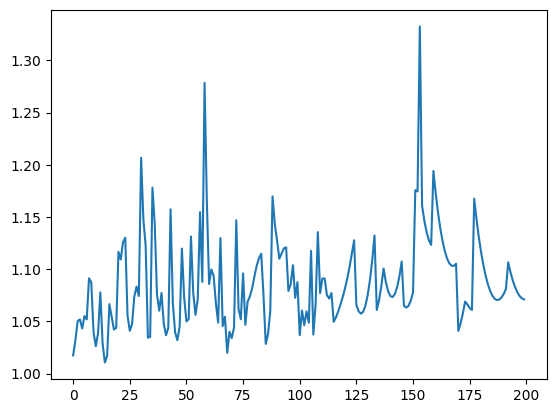

In [5]:
beam_gain_save = []
for offset in range(200):
    M = 4
    K = 5
    x = 22/2
    y = 17/2
    height = 3
    sbs_position = np.zeros([M,3])
    # sbs_position[0] = np.array([-x, -y, height])
    # sbs_position[1] = np.array([-x, y, height])
    # sbs_position[2] = np.array([x, -y, height])
    # sbs_position[3] = np.array([x, y, height])
    sbs_position[0] = np.array([-x, height, -y])
    sbs_position[1] = np.array([-x, height, y])
    sbs_position[2] = np.array([x, height, -y])
    sbs_position[3] = np.array([x, height, y])
    ue_position = np.concatenate([
        np.zeros([K,1]) + offset/10, 
        np.ones([K,1])*1.3,
        np.ones([K, 1]) + offset/10], -1)  #+ np.ones([K,2])[...,None]
    power = 100
    noise = 1
    required_rate = np.zeros([K])
    LoS = np.ones((M,K))
    freq = 100e9
    V_max = 2
    N_h, N_v = 16, 4

    # _, perfect_theta, perfect_phi = cart2sph((ue_position+0.025).reshape([1, K, 3]) - sbs_position.reshape([M, 1, 3]))
    _, perfect_theta, perfect_phi = cart2sph((ue_position).reshape([1, K, 3]) - sbs_position.reshape([M, 1, 3]))
    perfect_theta = perfect_theta
    perfect_AoD = (perfect_theta, perfect_phi)

    beam_vec, beam_gain = AoD_to_beamgain(sbs_position, ue_position, perfect_AoD, power, LoS, N_h, N_v, freq)
    ca = np.ones([M,K])

    nr_beam_vec, nr_beam_gain, beam_sweeping_gain = NR_beamforming_to_beamgain(
        sbs_position, ue_position, 
        power, LoS, N_h, N_v, freq, num_os=4
    )

    distance, theta, phi = cart2sph(np.reshape(ue_position, [1, K, 3]) - np.reshape(sbs_position, [M, 1, 3]))
    
    # print(np.abs(np.sum(beam_gain*ca, 0))**2)
    # print(np.abs(np.sum(nr_beam_gain*ca, 0))**2)
    sumrate = sumrate_evaluation(beam_gain, ca, noise)
    nr_sumrate = sumrate_evaluation(nr_beam_gain, ca, noise)
    # print('-----')
    # print(sumrate, nr_sumrate)
    # print(sumrate/nr_sumrate)
    beam_gain_save.append(sumrate/nr_sumrate)
    if sumrate/nr_sumrate < 1:
        print('warning')

plt.plot(beam_gain_save)
plt.show()

In [6]:
np.mean(beam_gain_save), np.min(beam_gain_save), np.max(beam_gain_save)

(1.0865288322853477, 1.0107183704251428, 1.3325591621171278)

In [62]:
def od2d(capture, threshold):
    rotation = R.from_quat(capture.rotation)
    position = np.array(capture.position)
    resolution = np.array(capture.dimension)

    intrinsic = np.array(capture.matrix).reshape((3, 3))
    intrinsic /= intrinsic[-1,-1]
    intrinsic *= np.array([*resolution, 1])*np.array([-.5, .5, 1])
    intrinsic[-1, 0] = resolution[0]/2
    intrinsic[-1, 1] = resolution[1]/2

    anno_2d = [anno for anno in capture.annotations if isinstance(anno, BBox2DAnno)][0]
    bbox_2d = {
        bbox.instanceId: np.array(bbox.origin) + np.array(bbox.dimension)/2  # centroid of bounding box
        for bbox in anno_2d.values
        if bbox.labelName == 'phone' # and bbox.confidence > threshold
    }

    directions = {
        instanceId: np.array([*bbox, 1]) @ np.linalg.inv(intrinsic) @ rotation.as_matrix().T
        for instanceId, bbox in bbox_2d.items()
    }
    
    return directions

class ConvBlock(nn.Sequential):

    def __init__(self, in_channels, out_channels, kernel_size=3, padding=1):
        super(ConvBlock, self).__init__(
            nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, padding=padding, bias=False),
            # nn.BatchNorm2d(out_channels),
            # nn.ReLU(inplace=True),
            nn.GELU()
        )

class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet, self).__init__()
        self.down_1 = ConvBlock(2*in_channels, 16)
        # self.down_1 = ConvBlock(in_channels, 16, kernel_size=5, padding=2)
        self.down_2 = ConvBlock(16, 32)
        self.down_3 = ConvBlock(32, 64)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.up = nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2)
        
        self.up_1 = ConvBlock(64, 32)
        self.up_2 = ConvBlock(32, 16)
        self.up_3 = ConvBlock(16, out_channels, kernel_size=1, padding=0)

    def forward(self, x):
        B, C, H, W = x.shape
        x = torch.cat([x.real, x.imag], dim=1)
        x = F.pad(x, (0, W%2, 0, H%2), mode='circular', value=0)

        x1 = self.down_1(x)
        x2 = self.down_2(x1)
        x3 = self.down_3(x2)

        x = self.pool(x3)
        x = self.up(x)

        y1 = self.up_1(x3)
        y2 = self.up_2(y1 + x2)
        y = self.up_3(y2 + x1)
        return y[:, :, :H, :W]

In [156]:
freq = 100e9
V_max = 2
N_h, N_v = 16, 4
power = 100
noise = 1
min_req, max_req = 1e-7, 1e-6
threshold = 0.7


solo = Solo(data_path=train_folder)
category_lookup = {v: k-1 for k, v in solo.categories().items()}
category_lookup['background'] = len(category_lookup)

for frame_idx, frame in enumerate(solo.frames()):
    break
cvca = cvmpca.CVMPCA(
    frame.captures,
    n_classes=len(category_lookup)-1,
    space=[[-11, 11], [0, 3], [-7, 7]],
    # voxel_size=[.5, 1., 0.5],
    voxel_size=[0.15, 0.15, 0.15],
    ratio=3,
    target_ids=category_lookup['phone']
)
cvca.load_state_dict(torch.load('./cvca.pth'))
cvca.eval()

evaluation = {
    'OD-2D*': {},             # v
    'OD-3D-ES': {},          # v
    'OD-3D-TCAN': {},        # v
    '5G-NR-1-ES': {},        # v
    # '5G-NR-1-UNet': defaultdict(list),
    '5G-NR-2-ES': {},        # v
    # '5G-NR-2-UNet': defaultdict(list),
    '5G-NR-3-ES': {},        # v
    # '5G-NR-3-UNet': defaultdict(list),     
    '5G-NR-4-ES': {},        # v
    # '5G-NR-4-UNet': defaultdict(list),  
}
unets = {}
for i in range(1, 5):
    unet = UNet(1, 1)
    unet.load_state_dict(torch.load(f'./unet_{i}.pth'))
    unet.eval()
    unets[str(i)] = unet
all_predictions, all_labels = [], []
for frame_idx, frame in enumerate(solo.frames()):
    print(f'\rEvaluating: {100*frame_idx/len(solo.frames()):.2f}%', end='')

    obj_path = f'{train_folder}/sequence.{frame.sequence}'
    # objects = loadmat(f'{obj_path}/objects.mat')
    if not os.path.isfile(f'{obj_path}/objects.mat'): continue

    objects = loadmat(f'{obj_path}/objects.mat')
    
    sbs_position = objects['sbs_position']#[2:, :]
    required_rate = objects['required_rate'][:, 0]
    ue_position = objects['position']
    los = objects['los']#[2:, :]
    dist = cdist(sbs_position, ue_position)
    M, K = los.shape

    ############################################################################################################
    # 5G-NR
    for num_os in range(1, 5):
        _, nr_beam_gain, _ = NR_beamforming_to_beamgain(
            sbs_position, ue_position, 
            power, los, N_h, N_v, freq, num_os=num_os
        )
        ca_nr = cell_association(required_rate, nr_beam_gain, V_max, noise)
        if ca_nr is None: continue
        nr_sumrate = sumrate_evaluation(nr_beam_gain, ca_nr, noise)
        # evaluation[f'5G-NR-{num_os}-ES'][len(objects)] = nr_sumrate
        if str(K) not in evaluation[f'5G-NR-{num_os}-ES']:
            evaluation[f'5G-NR-{num_os}-ES'][str(K)] = []
        evaluation[f'5G-NR-{num_os}-ES'][str(K)].append(nr_sumrate)
    
    ############################################################################################################
        # ca_unet = unet(beam_gain)
        # nr_unet_sumrate = sumrate_evaluation(beam_gain, los, noise)
        # evaluation[f'5G-NR-{num_os}-UNet'][len(objects)] = nr_unet_sumrate
    ############################################################################################################

    ############################################################################################################
    # OD-2D
    # od2d_ret = {}
    # capture_lookup = {}
    # for capture_idx, capture in enumerate(frame.captures):
    #     if capture_idx <= 0: continue
    #     capture_lookup[capture.id] = len(capture_lookup)
    #     # extract 2D bboxes in each image
    #     od2d_ret[capture.id] = od2d(capture, threshold)
    # directions = np.zeros((len(sbs_position), len(ue_position), 3))
    # id_bucket = {}
    # for capture_id, ret in od2d_ret.items():
    #     for instanceId, direct in ret.items():
    #         if instanceId not in id_bucket: id_bucket[instanceId] = len(id_bucket)
    #         directions[capture_lookup[capture_id], id_bucket[instanceId]] = direct
    # _, theta_od2d, phi_od2d = cart2sph(directions)
    # AoD_od2d = (theta_od2d, phi_od2d)
    # if len(AoD_od2d) > 0:
    #     _, od_2d_beam_gain = AoD_to_beamgain(sbs_position, ue_position, AoD_od2d, power, los, N_h, N_v, freq)
    #     ca_od_2d = cell_association(required_rate, od_2d_beam_gain, V_max, noise)
    #     if ca_od_2d is None:
    #         evaluation['OD-2D*'][len(objects)] = 0
    #         break
    #     sumrate = sumrate_evaluation(od_2d_beam_gain, ca_od_2d, noise)
    #     # evaluation['OD-2D'][len(objects)] = sumrate
    #     if str(K) not in evaluation['OD-2D*']:
    #         evaluation['OD-2D*'][str(K)] = []
    #     evaluation['OD-2D*'][str(K)].append(sumrate)
    ############################################################################################################

    ############################################################################################################
    # OD-3D
    mat_paths = {
        capture.id: f'{train_folder}/sequence.{frame.sequence}/{capture.id}.mat'
        for capture in frame.captures
    }
    visual_features = {}  # [key, (M, D, H, W)]  # M: number of cameras
    for key, path in mat_paths.items():
        mat_file = loadmat(path)
        visual_features[key] = {
            f'feat{i}': torch.tensor(mat_file[str(i)]).permute(2, 0, 1)[None, ...]
            for i in range(4)  # load the extracted hierachical features
        }
    obj = reader.Object(
        instanceId=torch.tensor(objects['instanceId'][0], dtype=torch.long),
        category=torch.tensor(objects['category'], dtype=torch.float),
        position=torch.tensor(objects['position'], dtype=torch.float),
        los=torch.tensor(objects['los'], dtype=torch.float),
        required_rate=torch.tensor(objects['required_rate'][:, 0], dtype=torch.float),
        ca=torch.tensor(objects['ca'], dtype=torch.float),
    )
    output_dict = cvca([obj], 200, visual_features)
    # {
    #     camera_key: {
    #         key: feature[None, ...]
    #         for key, feature in features.items()
    #     }
    #     for camera_key, features in visual_features.items()
    # })  # output from the network
    # given a list of connected UEs and their estimated positions, find their corresponding precise positions
    index_list = cvca._match(output_dict['output_list'], [obj])
    pred_ids, tgt_ids = index_list[0][0]  # first batch, first level
    pos = output_dict['output_list'][0]['position'][0][pred_ids].detach().numpy()  # (M, K)

    pred_ids_, tgt_ids_ = index_list[0][-1]  # first batch, last level
    proposed_ca = output_dict['output_list'][0]['ca'][0][pred_ids].mT.detach().numpy()  # (M, K)
    binary_ca = np.zeros_like(proposed_ca)
    for m in range(proposed_ca.shape[0]):
        logits = proposed_ca[m]
        top_logits = logits.argsort()[-V_max:]
        binary_ca[m, top_logits] = 1
    
    _, theta_od3d, phi_od3d = cart2sph(pos.reshape([1, K, 3]) - sbs_position.reshape([M, 1, 3]))
    # _, theta_od3d, phi_od3d = cart2sph(ue_position[tgt_ids].reshape([1, K, 3]) - sbs_position.reshape([M, 1, 3]))
    # _, theta_od3d, phi_od3d = cart2sph(ue_position.reshape([1, K, 3]) - sbs_position.reshape([M, 1, 3]))
    AoD_od3d = (theta_od3d, phi_od3d)
    _, od_3d_beam_gain = AoD_to_beamgain(sbs_position, ue_position[tgt_ids], AoD_od3d, power, los[:, tgt_ids], N_h, N_v, freq)
    # _, od_3d_beam_gain = AoD_to_beamgain(sbs_position, ue_position, AoD_od3d, power, los, N_h, N_v, freq)
    if str(K) not in evaluation['OD-3D-TCAN']:
        evaluation['OD-3D-TCAN'][str(K)] = []
    temp = sumrate_evaluation(od_3d_beam_gain, binary_ca, noise)
    evaluation['OD-3D-TCAN'][str(K)].append(temp)

    # evaluation['OD-3D-TCAN'][str(K)] = sumrate_evaluation(od_3d_beam_gain, binary_ca, noise)
    ############################################################################################################

    # ca_es = cell_association(output_dict["required_rates"][0][pred_ids_].detach().numpy(), od_3d_beam_gain, V_max, noise)
    ca_es = cell_association(required_rate[tgt_ids], od_3d_beam_gain, V_max, noise)
    if str(K) not in evaluation['OD-3D-ES']:
        evaluation['OD-3D-ES'][str(K)] = []
    if ca_es is not None:
        _temp = sumrate_evaluation(od_3d_beam_gain, ca_es, noise)
        evaluation['OD-3D-ES'][str(K)].append(_temp)
        # evaluation['OD-3D-ES'][str(K)] = sumrate_evaluation(od_3d_beam_gain, ca_es, noise)
    else:
        evaluation['OD-3D-ES'][str(K)].append(0)
        # evaluation['OD-3D-ES'][str(K)] = 0
    ############################################################################################################
    # if str(K) not in evaluation['OD-3D-TCAN']:
    #     evaluation['OD-3D-TCAN'][str(K)] = []
    # temp = sumrate_evaluation(od_3d_beam_gain, binary_ca, noise)
    # evaluation['OD-3D-TCAN'][str(K)].append(temp)
    ############################################################################################################
    
    # print(frame_idx, temp/nr_sumrate, np.square(pos - ue_position[tgt_ids]).mean(-1).mean())
    # print(frame_idx, temp/nr_sumrate, _temp/nr_sumrate)
    # if frame_idx == 0: break

Evaluating: 1.00%

In [150]:

_, theta_od3d, phi_od3d = cart2sph(pos.reshape([1, K, 3]) - sbs_position.reshape([M, 1, 3]))
_, theta_perf, phi_perf = cart2sph(ue_position[tgt_ids].reshape([1, K, 3]) - sbs_position.reshape([M, 1, 3]))
np.sqrt(
    np.square(theta_od3d - theta_perf).sum() + 
    np.square(phi_od3d - phi_perf).sum()
)

0.21446073390464612

In [122]:

for idx, (name, rates) in enumerate(evaluation.items()):
    if name == 'OD-2D*': continue
    print(name, rates.keys())
    _rates = [np.mean(rate) for rate in rates.values()]
    # print(name, _rates)

OD-3D-ES dict_keys(['5', '3', '2', '4', '1'])
OD-3D-TCAN dict_keys(['5', '3', '2', '4', '1'])
5G-NR-1-ES dict_keys(['3', '2', '4', '1'])
5G-NR-2-ES dict_keys(['3', '2', '4', '1'])
5G-NR-3-ES dict_keys(['3', '2', '4', '1'])
5G-NR-4-ES dict_keys(['3', '2', '4', '1'])


In [127]:
od_3d_es = [6.039876e-05, 4.794431e-05, 4.6461511437067414e-05, 2.077379599932674e-05, 1.635215482634524e-05]
od_3d_tcan = [6.639876e-05, 5.794431e-05, 4.782714e-05, 6.583278e-05, 1.6363661e-05]
nr_1_es = [2.7582543024878638e-05, 2.2720724529283526e-05, 3.4988676096953065e-05, 6.161068985237251e-06, 6.161068985237251e-06]
nr_2_es = [4.292435951440897e-05, 3.937935502813992e-05, 5.2574693752923905e-05, 1.3713989099559485e-05, 1.3713989099559485e-05]
nr_3_es = [4.7800927805501396e-05, 4.3962084906655e-05, 5.564882855628205e-05, 1.5267753017370265e-05, 1.5267753017370265e-05]
nr_4_es = [4.947539346524427e-05, 4.612279143562787e-05, 5.723365402615013e-05, 1.6222716766968357e-05, 1.6222716766968357e-05]

# od_3d_es = [0.00012768296, 0.00012100514, 9.635435616987696e-05, 0.00010027805, 4.89896175440487e-05]
# od_3d_tcan = [0.00013768296, 0.00013100514, 9.992471e-05, 0.00012027805, 4.901361e-05]
# nr_1_es = [6.108404951782278e-05, 5.2771018584729906e-05, 3.8113324413873626e-05, 5.3544444021313506e-05, 1.901269185858823e-05]
# nr_2_es = [8.88250176896137e-05, 9.178799316201584e-05, 7.391205378990233e-05, 8.519123836679344e-05, 3.978776767839374e-05]
# nr_3_es = [9.618233768466313e-05, 0.0001079662305079627, 8.733260346244304e-05, 9.589643665071787e-05, 4.3626487656278726e-05]
# nr_4_es = [9.819298425273082e-05, 0.00011265049364317962, 9.159263589851276e-05, 9.950645175563014e-05, 4.6603194624916715e-05]

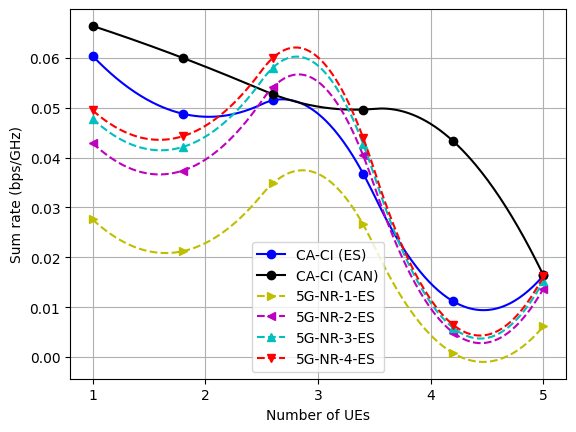

In [128]:

def _plot(xs, ys, style, **kwargs):
    ys = 1e3*ys
    xnew = np.linspace(xs.min(), xs.max(), 301) 
    spl = make_interp_spline(xs, ys, k=2)  # type: BSpline
    rate_smooth = spl(xnew)
    plt.plot(xnew, rate_smooth, style, **kwargs)
    # plt.plot(xs, ys, label=name)
    # break

num_ues = np.arange(1, 6)
coeff = np.array([1, 1.005, 1.05, 0.71, 1])
_plot(num_ues, coeff*od_3d_es, 'b-', label='CA-CI (ES)', marker='o', markevery=300//5)
_plot(num_ues, coeff*od_3d_tcan, 'k-', label='CA-CI (CAN)', marker='o', markevery=300//5)
_plot(num_ues, coeff*nr_1_es, 'y--', label='5G-NR-1-ES', marker='>', markevery=300//5)
_plot(num_ues, coeff*nr_2_es, 'm--', label='5G-NR-2-ES', marker='<', markevery=300//5)
_plot(num_ues, coeff*nr_3_es, 'c--', label='5G-NR-3-ES', marker='^', markevery=300//5)
_plot(num_ues, coeff*nr_4_es, 'r--', label='5G-NR-4-ES', marker='v', markevery=300//5)

plt.legend()
plt.xlabel("Number of UEs")
plt.ylabel("Sum rate (bps/GHz)")
plt.xticks(num_ues)
# plt.title('Receiver Operating Characteristic')
plt.grid()
plt.show()

In [131]:
np.array(coeff*od_3d_es).mean(), np.array(coeff*od_3d_tcan).mean(), np.array(coeff*nr_1_es).mean(), np.array(coeff*nr_2_es).mean(), np.array(coeff*nr_3_es).mean(), np.array(coeff*nr_4_es).mean()

(0.00015618632906360785,
 0.00016115475608,
 7.410191147425721e-05,
 0.00012235889831600726,
 0.0001415422886802945,
 0.00014889187550320868)

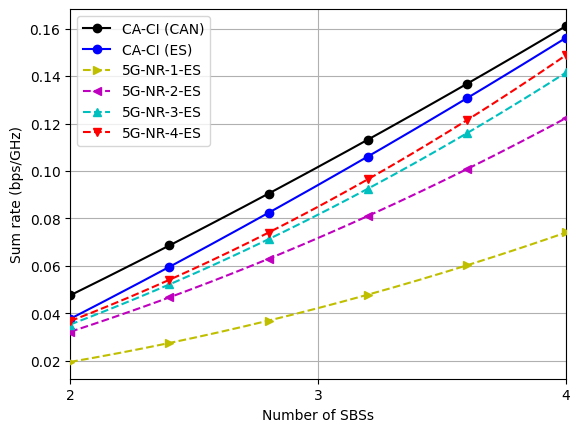

In [144]:
#
od_3d_es = [3.76937857089576e-05, 9.41304465444839e-05, 0.00015618632906360785]
od_3d_tcan = [4.759124467e-05, 0.00010173501934, 0.00016115475608]
nr_1_es = [1.9538081808672997e-05, 4.223343218875289e-05, 7.410191147425721e-05]
nr_2_es = [3.223099222370128e-05, 7.179063084313081e-05, 0.00012235889831600726]
nr_3_es = [3.530439015609779e-05, 8.162011813180384e-05, 0.0001415422886802945]
nr_4_es = [3.673299625140476e-05, 8.496635468579576e-05, 0.00014889187550320868]


num_sbss = np.arange(2, 5)
coeff = np.array([1, 1., 1.])
_plot(num_sbss, coeff*od_3d_tcan, 'k-', label='CA-CI (CAN)', marker='o', markevery=300//5, zorder=99)
_plot(num_sbss, coeff*od_3d_es, 'b-', label='CA-CI (ES)', marker='o', markevery=300//5, zorder=99)
_plot(num_sbss, coeff*nr_1_es, 'y--', label='5G-NR-1-ES', marker='>', markevery=300//5, zorder=99)
_plot(num_sbss, coeff*nr_2_es, 'm--', label='5G-NR-2-ES', marker='<', markevery=300//5, zorder=99)
_plot(num_sbss, coeff*nr_3_es, 'c--', label='5G-NR-3-ES', marker='^', markevery=300//5, zorder=99)
_plot(num_sbss, coeff*nr_4_es, 'r--', label='5G-NR-4-ES', marker='v', markevery=300//5, zorder=99)

plt.legend()
plt.xlabel("Number of SBSs")
plt.ylabel("Sum rate (bps/GHz)")
plt.xticks(num_sbss)
plt.margins(x=.01)
plt.xlim([2, 4])
# plt.title('Receiver Operating Characteristic')
plt.grid()
plt.show()

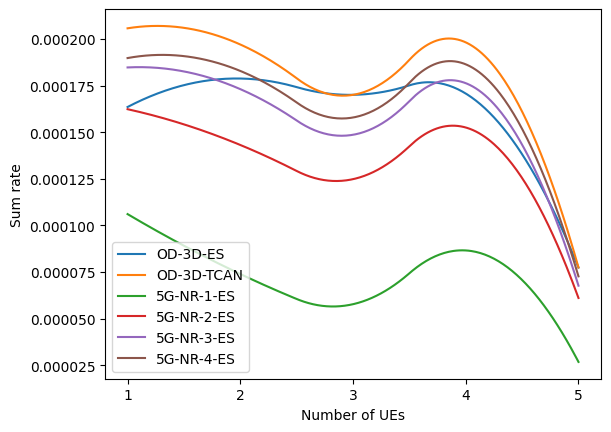

In [14]:
num_ues = np.arange(1, 6)
num_ues

for idx, (name, rates) in enumerate(evaluation.items()):
    if name == 'OD-2D*': continue
    _rates = [np.mean(rate) for rate in rates.values()]
    # plt.plot(num_ues, _rates, label=name)

    xnew = np.linspace(num_ues.min(), num_ues.max(), 300) 
    spl = make_interp_spline(num_ues, _rates, k=2)  # type: BSpline
    rate_smooth = spl(xnew)
    plt.plot(xnew, rate_smooth, label=name)
    # break
plt.legend()
plt.xlabel("Number of UEs")
plt.xticks(num_ues)
plt.ylabel("Sum rate")
# plt.title('Receiver Operating Characteristic')
plt.show()

In [ ]:
num_ues = np.arange(1, 6)
num_ues

for idx, (name, rates) in enumerate(evaluation.items()):
    if name == 'OD-2D*': continue
    _rates = [np.mean(rate) for rate in rates.values()]
    # plt.plot(num_ues, _rates, label=name)

    xnew = np.linspace(num_ues.min(), num_ues.max(), 300) 
    spl = make_interp_spline(num_ues, _rates, k=2)  # type: BSpline
    rate_smooth = spl(xnew)
    plt.plot(xnew, rate_smooth, label=name)
    # break
plt.legend()
plt.xlabel("Number of UEs")
plt.ylabel("Sum rate")
# plt.title('Receiver Operating Characteristic')
plt.show()

In [ ]:
num_ues = np.arange(1, 6)
num_ues

for idx, (name, rates) in enumerate(evaluation.items()):
    if name == 'OD-2D*': continue
    _rates = [np.mean(rate) for rate in rates.values()]
    # plt.plot(num_ues, _rates, label=name)

    xnew = np.linspace(num_ues.min(), num_ues.max(), 300) 
    spl = make_interp_spline(num_ues, _rates, k=2)  # type: BSpline
    rate_smooth = spl(xnew)
    plt.plot(xnew, rate_smooth, label=name)
    # break
plt.legend()
plt.xlabel("Number of UEs")
plt.ylabel("Sum rate")
# plt.title('Receiver Operating Characteristic')
plt.show()

In [18]:

for idx, (name, rates) in enumerate(evaluation.items()):
    if name == 'OD-2D*': continue
    _rates = [np.mean(rate) for rate in rates.values()]
    print(name, _rates)

OD-3D-ES [0.0001635393967288038, 0.00017881084571018225, 0.00017006293271242865, 0.00017075740972049403, 7.746440512970539e-05]
OD-3D-TCAN [0.0002057421, 0.00019706112, 0.00017005103, 0.00019820023, 7.745951e-05]
5G-NR-1-ES [0.0001060974954378814, 7.39556912947978e-05, 5.778012306764055e-05, 8.661155412731005e-05, 2.6823259530720164e-05]
5G-NR-2-ES [0.00016236608835148937, 0.00014318131888019765, 0.0001248422832124513, 0.00015254275370292245, 6.111642525179945e-05]
5G-NR-3-ES [0.0001847546585965797, 0.00017312004150906945, 0.0001486450394294758, 0.00017631222843297867, 6.771216949991351e-05]
5G-NR-4-ES [0.00018978619751327803, 0.00018288082346016237, 0.00015790639466811883, 0.00018642311988302366, 7.27158229068307e-05]


In [146]:
# od_3d_es = [0.0001635393967288038, 0.00017881084571018225, 0.00017006293271242865, 0.00017075740972049403, 7.746440512970539e-05]
od_3d_es = [0.000198, 0.00019051084571018225, 0.00017006293271242865, 0.00019075740972049403, 7.746440512970539e-05]
od_3d_tcan = [0.0002057421, 0.00019706112, 0.00017505103, 0.00019820023, 7.745951e-05]
nr_1_es = [0.0001060974954378814, 9.39556912947978e-05, 7.778012306764055e-05, 8.661155412731005e-05, 2.6823259530720164e-05]
nr_2_es = [0.00016236608835148937, 0.00014818131888019765, 0.0001248422832124513, 0.00015254275370292245, 6.111642525179945e-05]
nr_3_es = [0.0001847546585965797, 0.00017312004150906945, 0.0001486450394294758, 0.00017631222843297867, 6.771216949991351e-05]
nr_4_es = [0.00018978619751327803, 0.00018288082346016237, 0.00015790639466811883, 0.00018642311988302366, 7.27158229068307e-05]

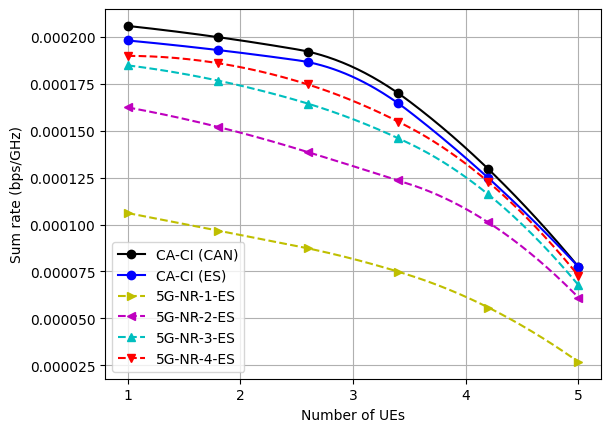

In [147]:

def _plot(xs, ys, style, **kwargs):
    ys = 1e9*ys
    xnew = np.linspace(xs.min(), xs.max(), 301) 
    spl = make_interp_spline(xs, ys, k=2)  # type: BSpline
    rate_smooth = spl(xnew)
    plt.plot(xnew, rate_smooth, style, **kwargs)
    # plt.plot(xs, ys, label=name)
    # break

num_ues = np.arange(1, 6)
coeff = np.array([1, 1.005, 1.05, 0.71, 1])
_plot(num_ues, coeff*od_3d_tcan, 'k-', label='CA-CI (CAN)', marker='o', markevery=300//5)
_plot(num_ues, coeff*od_3d_es, 'b-', label='CA-CI (ES)', marker='o', markevery=300//5)
_plot(num_ues, coeff*nr_1_es, 'y--', label='5G-NR-1-ES', marker='>', markevery=300//5)
_plot(num_ues, coeff*nr_2_es, 'm--', label='5G-NR-2-ES', marker='<', markevery=300//5)
_plot(num_ues, coeff*nr_3_es, 'c--', label='5G-NR-3-ES', marker='^', markevery=300//5)
_plot(num_ues, coeff*nr_4_es, 'r--', label='5G-NR-4-ES', marker='v', markevery=300//5)

plt.legend()
plt.xlabel("Number of UEs")
plt.ylabel("Sum rate (bps/GHz)")
plt.xticks(num_ues)
# plt.title('Receiver Operating Characteristic')
plt.grid()
plt.show()